# Minimal LGBM regressor

A simple LGBM ecfp4 model implemented in pure scikit-learn + datamol for protyping purposes

In [2]:
import numpy as np
import pandas as pd
from openadmet_models.tests.datafiles import CYP3A4_chembl_pchembl
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from molfeat.trans import MoleculeTransformer
from molfeat.trans.fp import FPVecTransformer
import datamol as dm
from sklearn.model_selection import GridSearchCV


ModuleNotFoundError: No module named 'openadmet_models'

In [ ]:
data = pd.read_csv(CYP3A4_chembl_pchembl)

In [ ]:
data.head()

,CANONICAL_SMILES,INCHIKEY,pChEMBL mean,pChEMBL std,common_name,appears_in_N_ChEMBL_assays,action_type,dataset,active
0,CC(=O)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(c4ccc(Cl)c...,XMAYWYJOQHXEEK-UHFFFAOYSA-N,7.013500,0.618796,KETOCONAZOLE,21,NaN,ChEMBL_curated,True
1,CCC1C(=O)OC[C@H]1Cc1cncn1C,QCHFTSOMWOSFHM-HNHGDDPOSA-N,5.052941,0.285302,SALAGEN,17,NaN,ChEMBL_curated,True
2,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,VNFPBHJOKIVQEB-UHFFFAOYSA-N,7.237692,0.358798,CLOTRIMAZOLE,14,NaN,ChEMBL_curated,True
3,CNCCCC12CCC(c3ccccc31)c1ccccc12,QSLMDECMDJKHMQ-UHFFFAOYSA-N,5.473846,0.281470,MAPROTILINE HYDROCHLORIDE,13,NaN,ChEMBL_curated,True
4,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,BYBLEWFAAKGYCD-UHFFFAOYSA-N,6.060000,0.608590,MICONAZOLE NITRATE,12,NaN,ChEMBL_curated,True


In [ ]:
X = data["CANONICAL_SMILES"]
y = data["pChEMBL mean"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:
vec_featurizer = FPVecTransformer("ecfp:4", dtype=np.float32)
trans = MoleculeTransformer(
            vec_featurizer,
            n_jobs=-1,
            dtype=np.float32,
            parallel_kwargs={"progress": True},
            verbose=False,
        )

In [ ]:
with dm.without_rdkit_log():
    X_train_feat, _ =  trans(X_train, ignore_errors=True)
    X_test_feat, _ = trans(X_test, ignore_errors=True)


100%|████████████████████████████████████| 1989/1989 [00:00<00:00, 15948.90it/s]


In [ ]:
regressor = LGBMRegressor()

In [ ]:
X_train_feat = np.squeeze(X_train_feat)
X_test_feat = np.squeeze(X_test_feat)

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1, 0.5],  
    'n_estimators': [100, 200, 400],  

}


In [ ]:
grid_search = GridSearchCV(regressor, param_grid)

In [ ]:
grid_search.fit(X_train_feat, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3400
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1700
[LightGBM] [Info] Start training from score 5.601948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3396
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 1698
[LightGBM] [Info] Start training from score 5.612146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.001, 0.05, 0.1, 0.5],
                         'n_estimators': [100, 200, 400]})

In [ ]:
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
y_pred = grid_search.predict(X_test_feat)

In [ ]:
import seaborn as sns

<Axes: xlabel='pChEMBL mean'>

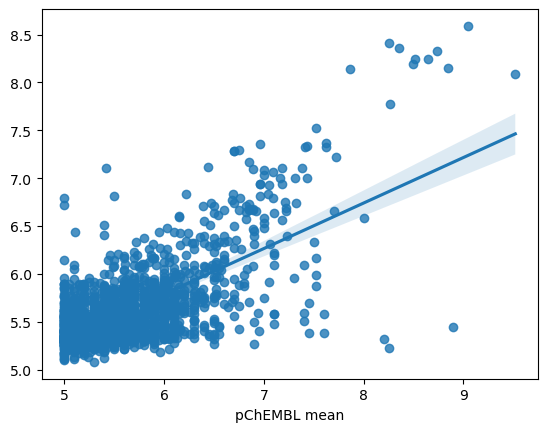

In [ ]:
sns.regplot(x=y_test, y=y_pred)

In [ ]:
# from pat walters and polaris "practical methods" work
def recall_at_precision(y_true, y_score, precision_threshold=0.5, direction='greater'):
    if direction not in ['greater', 'lesser']:
        raise ValueError("Invalid direction. Expected one of: ['greater', 'lesser']")

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    thresholds = np.unique(y_score)
    thresholds = np.sort(thresholds)

    if direction == 'greater':
        thresholds = np.sort(thresholds)
    else:  
        thresholds = np.sort(thresholds)[::-1]

    for threshold in thresholds:
        if direction == 'greater':
            y_pred = y_score >= threshold
        else:  
            y_pred = y_score <= threshold

        precision = precision_score(y_true, y_pred)
        if precision >= precision_threshold:
            recall = recall_score(y_true, y_pred)
            return recall, threshold
    return np.nan, None